## Value-At-Risk: Mixture of Gaussian Distributions

note:  consider to split it into data preparation to check for:
- normality
- stationarity
- serial correlation


1. Check series for normality
2. Construct the Gaussian VaR model
3. Construct  the two component Gaussian mixture VaR model
4. Select the number of components in the Gaussian mixture
5. Asses the performance of the model

In [93]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn
plt.style.use(['seaborn-ticks'])
# plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 10.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.tight_layout()
%matplotlib inline


from sklearn.mixture import GaussianMixture
from scipy.optimize import newton
from scipy.stats import norm

import pandas_datareader.data as ds

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
from common.utils import groupby_subplot
from analytics.financials.utils import nday_return
from analytics.mlearn.utils import select_n_components


def gmm_mixture():
    def f(n_components):
        return GaussianMixture(n_components, covariance_type='full', random_state=0)

## Parameters of the Model

- estimation window 250 days
- holding period or risk horizon 1 day
- backtest window 250 days

In [214]:
# estimation window
est_window = 250
# risk horizon/holding period
nday = 1
start = pd.to_datetime('2013-01-01')
end = pd.to_datetime('2017-12-31')

### Load Market Data

In [127]:
df_y = ds.DataReader('AAPL', 'iex', start, end)['close']

5y


In [128]:
df_y = ds.DataReader('SPY', 'iex', start, end)['close']
np.log(df_y['2017-09-25']) - np.log(df_y['2017-09-22'])


5y


-0.0020466384619490796

### Construct log-return series

In [148]:
df = pd.DataFrame({'level': df_y.iloc[nday:],
                   'logrtn': nday_return(df_y, nday=nday, log=False).iloc[nday:]})

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
0,250.0,0.000787,0.007210,-0.025408,-0.003233,0.000985,0.005478,0.021103
1,250.0,0.000507,0.007385,-0.021484,-0.003466,0.000928,0.004732,0.024132
2,250.0,-0.000134,0.010545,-0.042627,-0.004819,-0.000167,0.005172,0.036974
3,250.0,0.000714,0.006312,-0.037808,-0.002391,0.000510,0.004117,0.021581
4,203.0,0.000653,0.004303,-0.018065,-0.001195,0.000486,0.002329,0.010878


### Check for normality

A normality assumption, which is common among practitioners while modeling returns, is often advocated due to it simplicity and comfort in computations. Although, the normality assumption might hold for some periods in the return series, it is often violated. To see this let's plot quantile plot to compare log return distribution to that of Normal distribution for each year.

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
0,250.0,0.000787,0.007210,-0.025408,-0.003233,0.000985,0.005478,0.021103
1,250.0,0.000507,0.007385,-0.021484,-0.003466,0.000928,0.004732,0.024132
2,250.0,-0.000134,0.010545,-0.042627,-0.004819,-0.000167,0.005172,0.036974
3,250.0,0.000714,0.006312,-0.037808,-0.002391,0.000510,0.004117,0.021581
4,203.0,0.000653,0.004303,-0.018065,-0.001195,0.000486,0.002329,0.010878


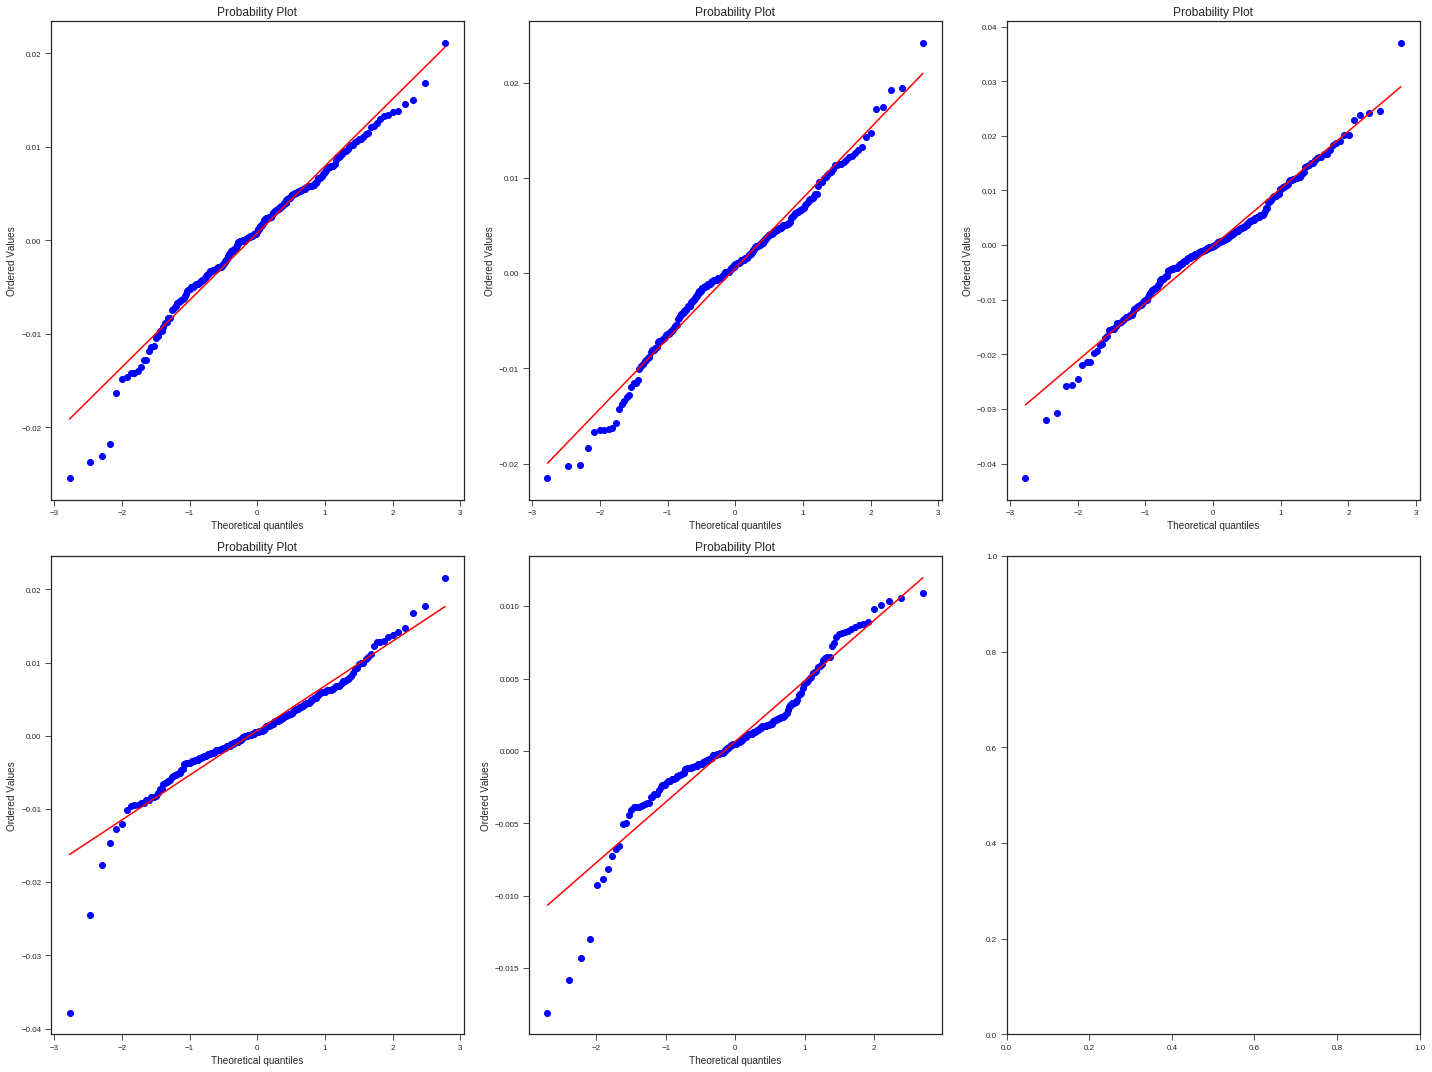

In [174]:
N = df.shape[0]
df['grp'] = list(map(lambda x: int(x/est_window)  - 1 * (x % est_window == 0), list(range(1, N + 1))))
df_grouped = df.groupby('grp')
nyear = df_grouped.ngroups
df_grouped['logrtn'].describe()

groupby_subplot(df_grouped, columns='logrtn', plot=lambda x: stats.probplot(x, dist="norm", plot=plt), ncol=3, figsize=(20,15), ticksize=(8,8))

### Gaussian Mixture Model

In [215]:
# backtest window
bktest_window = 250
total_nofobs = bktest_window + est_window
data = df[['logrtn','level']].values[- total_nofobs:]

In [216]:
today = data.shape[0] -1
p_today = data[today, 1]
p_lagged = data[today - nday, 1]
assert(abs(np.log(p_today/p_lagged) - data[today,0]) < 10**(-4))
X = data[today - nday - est_window:today - nday, 0, None]

#### Select the Number of Mixture Components

In [217]:
gmm = lambda n_components: GaussianMixture(n_components, init_params='kmeans')
maxcomp = 10
n_components_bic, n_components_aic, m_bic, m_aic = select_n_components(X, mixture=gmm, maxcomp=maxcomp)

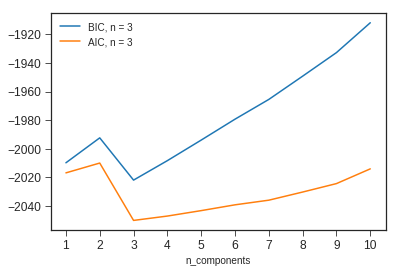

In [225]:
n_components = np.arange(1, maxcomp + 1)
plt.plot(n_components, m_bic, label='BIC, n = {}'.format(n_components_bic))
plt.plot(n_components, m_aic, label='AIC, n = {}'.format(n_components_aic))
plt.legend(loc='best');
plt.xlabel('n_components');
ax = plt.gca();
ax.set_xticks(n_components);

In [219]:
gmm = GaussianMixture(n_components=n_components_aic)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [220]:
print(gmm.means_.flatten())
print(gmm.covariances_.flatten())
print(gmm.weights_)

[  5.94210589e-03   5.08865851e-05  -9.88612596e-03]
[  1.18973891e-05   7.57828693e-06   2.94799557e-05]
[ 0.1871834   0.77405476  0.03876184]


In [223]:
# backtesting - start
def simple_normal_model(X):
    # simple normal density estimation
    d = norm(X.mean(), X.std())
    def sample(n):
        return [d.rvs(n)]
    simple_normal_model.sample = sample
    return simple_normal_model



def mixture_model(X, mixture, ic='aic', maxcomp = 5):
    # select the number components in the Gaussian mixture model
    n_components_bic, n_components_aic, m_bic, m_aic = select_n_components(X, mixture, maxcomp=maxcomp)
    if ic == 'aic':
        n_components = n_components_aic
    elif ic == 'bic':
        n_components = n_components_bic
    else:
        raise Exception('unknown ic parameter, expected aic or bic')

    # fit the model
    ret = mixture(n_components=n_components)
    ret.fit(X)
    
    return ret


def bootstraped_values(data, model):
    n = data.shape[0]
    p_lagged = data[n - 1, 1]
    nsmaple = 1000
    VaR_r = np.array([np.percentile(model.sample(nsmaple)[0], alpha * 100) for k in range(200)]).mean()
    return p_lagged * (np.exp(-VaR_r) - 1)
                       

def estimated_VaR(data, model, today, alpha):
    X = data[:, 0, None]
    
    # fit Gaussian Mixture Model
    m = model(X)
    
    # estimate the quantile with confidence level alpha
    n = 1000
    VaR = bootstraped_values(data, m)
    
    return VaR


def actual_PnL(data, today, nday):
    PnL =  np.subtract(data[today, 1], data[today - nday, 1])
    return PnL


def backtest(data, window, models, nday, actual, expected_value,  **kwarg):
    """
    Parameter
    ---------
    model: function reference to estimation model 
    """
    
    def _get_data(nday):
        def f(data, today):
            _data = data[today - nday + 1 - est_window:today - nday + 1]
            return _data
        return f
    
    get_data = _get_data(nday)
    
    n = data.shape[0]
    bktest = np.arange(n - window, n)
    
    actuals = [list(actual(data, bktest, nday))]
    expected_values = [[expected_value(get_data(data, today), model, today, **kwarg) for today in bktest] for model in models]
    vals = actuals + expected_values
    vals = np.array(vals)
    return vals

# backtesting - end

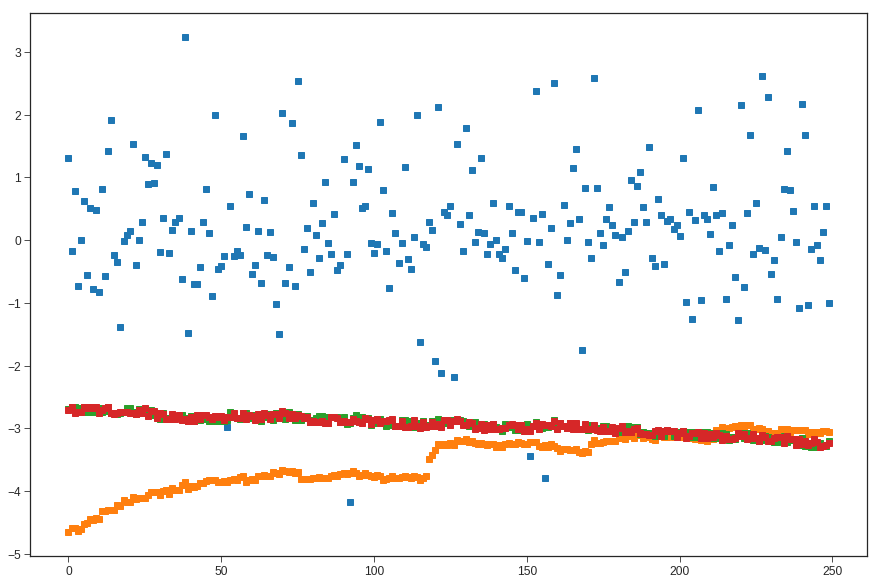

In [222]:

alpha = 0.995
bw = 250
gm = simple_normal_model
gmm_aic =  lambda x: mixture_model(X, mixture=GaussianMixture, ic='aic', maxcomp = 5)
gmm_bic =  lambda x: mixture_model(X, mixture=GaussianMixture, ic='bic', maxcomp = 5)

vals = backtest(data, window=bw, models=[gm, gmm_aic, gmm_bic], actual=actual_PnL, expected_value=estimated_VaR, nday=nday, alpha=alpha)
plt.figure(figsize=(15,10))
plt.plot(vals.transpose(), 's')

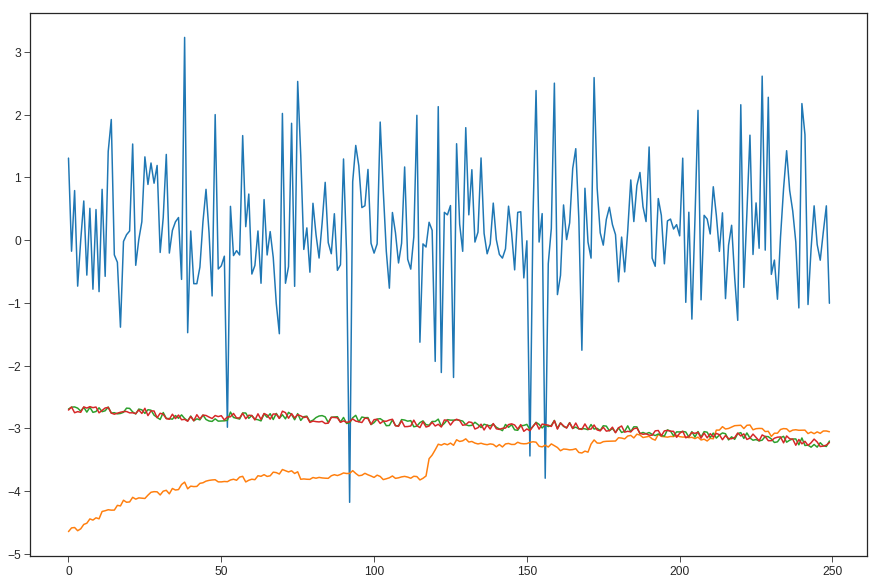

In [224]:
plt.figure(figsize=(15,10))
plt.plot(vals.transpose())

In [775]:
v = vals.T

# d[:,]
loss_= np.abs(v[v[:,0]<0,:])
print(loss_[(loss_[:,0] - loss_[:,1])>0,1].shape)
print(loss_[(loss_[:,0] - loss_[:,2])>0,2].shape)
print(loss_[(loss_[:,0] - loss_[:,3])>0,3].shape)
print('expected:', (1-alpha) * 300)
print(loss_)


(3,)
(3,)
(5,)
expected: 9.000000000000007
[[ 1.45        4.93983254  4.37012116  4.41821559]
 [ 1.3         5.03329642  4.47296776  4.45658063]
 [ 4.35        4.95266512  4.91899907  4.40859641]
 [ 1.39        4.98740471  4.48984398  4.46304441]
 [ 0.42        5.10095356  4.50702997  4.54043666]
 [ 1.94        5.16923069  4.64648477  4.65680788]
 [ 5.6         5.07311221  4.55621152  4.54874115]
 [ 1.12        5.1754665   4.60549833  4.60480855]
 [ 0.79        5.26429654  4.74150308  4.74833861]
 [ 3.37        5.12690711  4.58570924  4.61145139]
 [ 2.29        5.16411335  5.13793676  4.63792857]
 [ 1.62        5.25272197  5.19624289  4.65017274]
 [ 2.27        5.17753939  4.99739191  4.57248676]
 [ 1.8         5.23952362  5.10365236  4.63221953]
 [ 0.51        5.0247677   4.91636017  4.39646258]
 [ 3.52        4.93149807  4.82287745  4.27916634]
 [ 8.91        4.92887499  4.79678423  4.26564288]
 [ 5.28        5.07378322  4.92704714  4.41411195]
 [ 4.78        5.0810972   4.9491469   

[ 0.65135397  0.13094735  0.21769868]
[ -1.74372070e-05   7.32420318e-03  -6.07433535e-03]
-0.000374647553552
[ 0.00733592]
0.00992564040035
-0.000374647553552
7.51696295104e-06
(10000,)


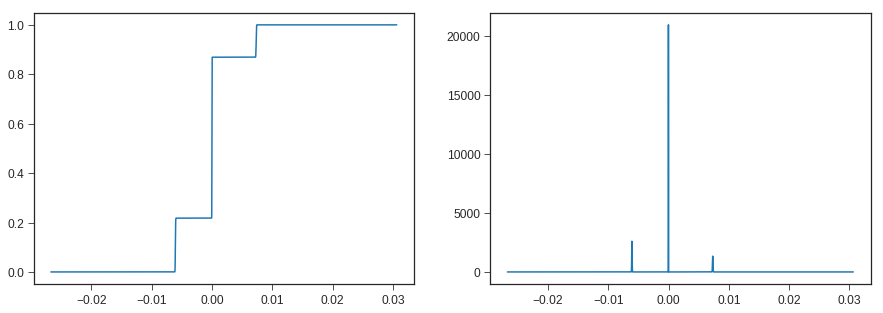

In [18]:
alpha = 0.95
ws = gmm.weights_
theta = list(zip(gmm.means_.flatten(), gmm.covariances_.flatten()))
cdfs = [norm(m,s).cdf for m, s in  theta]
pdfs = [norm(m,s).pdf for m, s in  theta]
f_mixture_cdf = weighted_funcs(ws, cdfs)
fprime = weighted_funcs(ws, pdfs)
f = quantile_eq(f_mixture_cdf, alpha)

print(gmm.weights_)
print(gmm.means_.flatten())
print(np.dot(ws,gmm.means_)[0])
print(newton(f, max(gmm.means_),fprime=fprime))
# print('newton dot: ', newton(f, np.dot(ws,gmm.means_)[0],fprime=fprime))

# k = 0
# print(norm(theta[k][0], theta[k][1]).ppf(0.995))
# print(norm(theta[k][0], theta[k][1]).ppf(0.95))

N = 1000
# print(np.percentile(norm(theta[k][0], theta[k][1]).rvs(N), alpha*100))
# print(f_mixture_cdf.ppf(0.995))
print(np.percentile(gmm.sample(N)[0], alpha*100))

mu = np.dot(ws, gmm.means_.flatten())
sig2 = np.dot(ws**2, gmm.covariances_.flatten())

x = np.linspace(mu - 100 * sig2, mu + 100 * sig2, 1000)
x = np.linspace(min(X), max(X), 10000)
print(mu)
print(sig2)
print(x.shape)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(x, f_mixture_cdf(x))
plt.subplot(1,2,2)
plt.plot(x, fprime(x))